# **Code Structure**

## 1 - Data Ingestion

<br>

## 2 - Data Preparation
### 2.1 - Data Cleaning
### 2.2 - Data Exploration
#### a) Target Indices
#### b) Futures

<br>

## 3 - Preliminary Analysis of Replication Target Index
### a) Target Definition: Maximum Annualized Return Index within a certain interval of SRRI
### b) Statistical Analysis

<br>

## 4 - Portfolio Replication
### a) Risk Constraint Setting
### b) Replication
### c) Result Visualization

In [ ]:
# Mount Google Drive to access files
# Skip remounting if already mounted
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
except:
    print("Drive already mounted or not in Colab environment.")


Mounted at /content/drive


In [ ]:
# Dealing with warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")

# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configure visualization settings
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Import for building the target index and statistical analysis
from scipy.optimize import minimize
import scipy.stats as stats
from datetime import timedelta

# Import for replication model
from itertools import product
from scipy.stats import skew, kurtosis
import statsmodels.api as sm
from scipy.stats import norm

# **1 - Data Ingestion**

In [ ]:
# Define the path to the dataset
# From the first dataset read the full names and Bloomberg tickers
# From the second read the time series
file_path = '/content/drive/MyDrive/FintechBusinessCases/BusinessCase3/Dataset/Dataset3_PortfolioReplicaStrategy.xlsx'
file_path_data = '/content/drive/MyDrive/FintechBusinessCases/BusinessCase3/Dataset/Dataset3_PortfolioReplicaStrategyErrataCorrige.xlsx'

# Reading the Excel file with specific structure:
# - Row 4 contains full names
# - Row 6 contains Bloomberg tickers
# - Data starts from row 7

# Read full names (row 4) skipping the first column (date column)
full_names_df = pd.read_excel(file_path, header=None, skiprows=3, nrows=1)
full_names = full_names_df.iloc[0].tolist()[1:]

# Read Bloomberg tickers (row 6) skipping the first column (date column)
tickers_df = pd.read_excel(file_path, header=None, skiprows=5, nrows=1)
tickers = tickers_df.iloc[0].tolist()[1:]

# Create a dictionary mapping tickers to full names
variable_info = dict(zip(tickers, full_names))

# Read the actual data without using any row as a header
data_raw = pd.read_excel(file_path_data, header=None, skiprows=1)

# First column is the date column
data_raw.columns = ['Date'] + tickers  # Assign the columns correctly using tickers

# Set the date column as the index and ensure it's in datetime format
data_raw['Date'] = pd.to_datetime(data_raw['Date'], format='%d/%m/%Y')
data = data_raw.set_index('Date')

In [ ]:
# Show the variable information (Ticker -> Full Name)
print("Bloomberg Ticker -> Full Name")
for ticker, name in variable_info.items():
    print(f"{ticker} -> {name}")

# Display statistical summary of the dataset
print("\nBasic statistics:")
display(data.describe())


Bloomberg Ticker -> Full Name
MXWO Index -> MSCI WORLD
MXWD Index -> MSCI ACWI
LEGATRUU Index -> Global Aggregate
HFRXGL Index -> Hedge Fund Research HFRX Globa
RX1 Comdty -> Generic 1st 'RX' Future
TY1 Comdty -> Generic 1st 'TY' Future
GC1 Comdty -> Generic 1st 'GC' Future
CO1 Comdty -> Generic 1st 'CO' Future
ES1 Comdty -> Generic 1st 'ES' Future
VG1 Comdty -> Generic 1st 'VG' Future
NQ1 Comdty -> Generic 1st 'NQ' Future
LLL1 Comdty -> Generic 1st 'LLL' Future
TP1 Comdty -> Generic 1st 'TP' Future
DU1 Comdty -> Generic 1st 'DU' Future
TU2 Comdty -> Generic 2nd 'TU' Future

Basic statistics:


,MXWO Index,MXWD Index,LEGATRUU Index,HFRXGL Index,RX1 Comdty,TY1 Comdty,GC1 Comdty,CO1 Comdty,ES1 Comdty,VG1 Comdty,NQ1 Comdty,LLL1 Comdty,TP1 Comdty,DU1 Comdty,TU2 Comdty
count,705.00000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000
mean,1644.12566,404.151915,452.203206,1210.092071,147.278837,125.966977,1317.902837,77.018496,1960.443050,3072.167631,4526.981206,1064.444113,1277.263121,110.221277,108.627682
std,443.39041,100.980126,47.338067,73.965200,19.318527,6.295242,274.477979,26.794278,770.070634,473.812729,2900.866833,128.954655,353.598276,2.374875,1.532632
min,705.35000,176.100000,342.247100,1021.400000,110.200000,110.515625,732.700000,19.330000,689.500000,1873.000000,1072.000000,465.100000,704.000000,102.190000,103.718750
25%,1293.43000,328.790000,431.737400,1158.150000,128.900000,121.203125,1178.000000,54.270000,1314.500000,2753.000000,2244.000000,1103.600000,905.000000,109.230000,107.871094
50%,1646.69000,402.570000,456.728800,1215.200000,148.000000,126.000000,1283.000000,72.050000,1909.250000,3071.000000,3884.750000,1103.600000,1302.500000,110.855000,109.093750
75%,1978.83000,478.410000,478.186800,1254.250000,163.240000,130.343750,1499.700000,105.780000,2569.750000,3433.000000,6333.250000,1103.600000,1587.500000,111.990000,109.906250
max,2944.05000,702.990000,559.311700,1415.110000,179.320000,140.328125,2001.200000,140.670000,4132.800000,4476.000000,13975.750000,1323.900000,1978.000000,112.720000,110.527344



# **2 - Data Preparation**





## **2.1 - Data Cleaning**

In [ ]:
# Count the number of empty values in each column
print("Empty values per column")
empty_per_column = (data == ' ').sum()
print(empty_per_column) # No empty values, hence no further action is required

Empty values per column
MXWO Index        0
MXWD Index        0
LEGATRUU Index    0
HFRXGL Index      0
RX1 Comdty        0
TY1 Comdty        0
GC1 Comdty        0
CO1 Comdty        0
ES1 Comdty        0
VG1 Comdty        0
NQ1 Comdty        0
LLL1 Comdty       0
TP1 Comdty        0
DU1 Comdty        0
TU2 Comdty        0
dtype: int64


In [ ]:
# Count number of NaN values for each feature
print(f"Number of NaN values per column: \n{data.isna().sum()}") # No NaN values, hence no further action is required

Number of NaN values per column: 
MXWO Index        0
MXWD Index        0
LEGATRUU Index    0
HFRXGL Index      0
RX1 Comdty        0
TY1 Comdty        0
GC1 Comdty        0
CO1 Comdty        0
ES1 Comdty        0
VG1 Comdty        0
NQ1 Comdty        0
LLL1 Comdty       0
TP1 Comdty        0
DU1 Comdty        0
TU2 Comdty        0
dtype: int64


## **2.2 - Data Exploration**

### a) Target Indices


First of all, we calculate basic statistics for the indices.

In [ ]:
# Calculate and display statistics for all indices
print("\nReturn statistics for target indices:")

# Target indices to explore
target_indices = ['MXWO Index', 'MXWD Index', 'LEGATRUU Index', 'HFRXGL Index']

# Calculate returns
returns = data[target_indices].pct_change().dropna()

# Format as percentage with 2 decimal places
def format_pct(x):
    return f"{x*100:.2f}%"

statistic = pd.DataFrame({
    'Annualized Return': returns.mean() * 52,
    'Annualized Volatility': returns.std() * np.sqrt(52),
    'Sharpe Ratio': (returns.mean() * 52) / (returns.std() * np.sqrt(52)),
    'Max Drawdown': returns.apply(lambda x: (1 + x).cumprod().div((1 + x).cumprod().cummax()) - 1).min(),
    'Skewness': returns.skew(),
    'Kurtosis': returns.kurtosis()
})

# Convert some columns to percentage format for better readability
for col in ['Annualized Return', 'Annualized Volatility', 'Max Drawdown']:
    statistic[col] = statistic[col].apply(format_pct)

display(statistic)


Return statistics for target indices:


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Skewness,Kurtosis
MXWO Index,5.90%,17.52%,0.336955,-57.61%,-0.682289,4.357034
MXWD Index,5.51%,17.78%,0.309683,-58.39%,-0.641270,4.663275
LEGATRUU Index,3.37%,5.34%,0.630472,-10.41%,-0.329675,4.118169
HFRXGL Index,0.50%,4.78%,0.104156,-24.91%,-2.301318,13.702270


Next, we study the correlations between the indices to identify the subset that will be used to build the target index for replication.

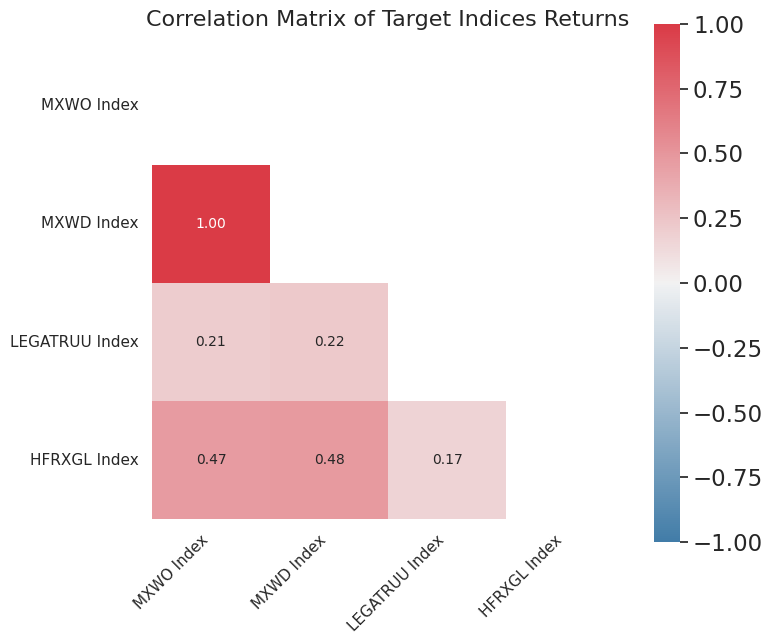

In [ ]:
# Use white background style
sns.set_style("white")

# Compute correlation matrix from the target indices
correlation_matrix = returns[target_indices].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(8, 8))

# Define a diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the updated style
sns.heatmap(correlation_matrix,
            mask=mask,
            cmap=cmap,
            vmax=1, vmin=-1,
            center=0,
            square=True,
            linewidths=0,  # No gridlines
            cbar_kws={"shrink": .75},
            annot=True, fmt=".2f",
            annot_kws={"size": 10})

# Titles and layout
plt.title("Correlation Matrix of Target Indices Returns", fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()


### b) Futures


Have a brief overview of the historical performance of the futures.

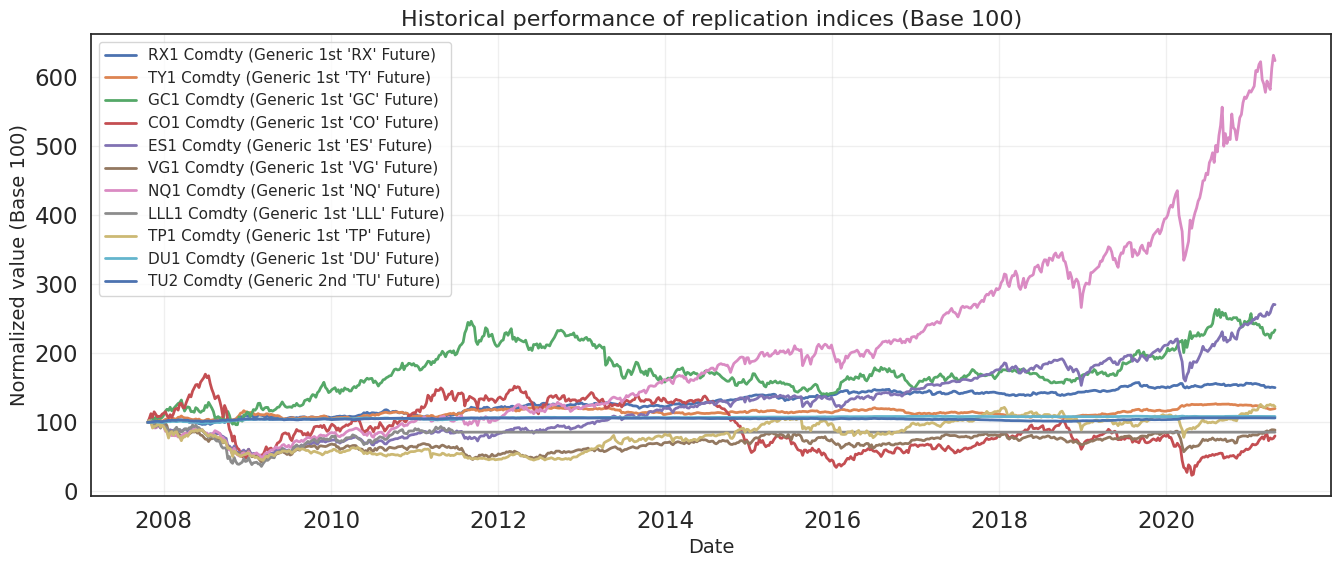

In [ ]:
# Define the futures contracts we'll use for replication
futures_contracts = [
    'RX1 Comdty', 'TY1 Comdty', 'GC1 Comdty', 'CO1 Comdty',
    'ES1 Comdty', 'VG1 Comdty', 'NQ1 Comdty', 'LLL1 Comdty',
    'TP1 Comdty', 'DU1 Comdty', 'TU2 Comdty'
]

# Calculate returns for futures contracts
futures_returns = data[futures_contracts].pct_change().dropna()

# Create a figure for the historical price series
plt.figure(figsize=(16, 6))

# Plot each index
for idx in futures_contracts:
    # Normalize to 100 at the beginning for comparison
    normalized_series = data[idx] / data[idx].iloc[0] * 100
    plt.plot(normalized_series.index, normalized_series, linewidth=2, label=f"{idx} ({variable_info.get(idx, idx)})")

# Format the plot
plt.title('Historical performance of replication indices (Base 100)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Normalized value (Base 100)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=11);

# **3 - Preliminary Analysis of Replication Target Index**

## a) Target Definition: Maximum Annualized Return Index within a certain interval of SRRI
We consider the Synthetic Risk and Reward Indicator (SRRI) as the risk measure for the product we intend to create (see [CESR’s guidelines on the methodology for the calculation of the SRRI in the Key Investor Information Document](https://www.esma.europa.eu/sites/default/files/library/2015/11/10_673.pdf)).
Specifically, we identify the target risk interval within which the new product should fall, and among the possible portfolios whose SRRI lies within this range, we select the one with the highest annualized return.

In [ ]:
def calculate_synthetic_risk_reward_indicator(returns_series):
    """
    Calculate the Synthetic Risk and Reward Indicator according to the CESR's methodology at page 5 of the paper linked above

    Parameters:
    -----------
    returns_series : pd.Series
        Series containing returns data

    Returns:
    --------
    float
        The Synthetic Risk and Reward Indicator
    """
    # Extract returns series and drop NaN values
    returns = returns_series.dropna()

    # Filter to last 5 years Of data. iF available
    dates = pd.to_datetime(returns.index)
    cutoff_date = dates.max() - timedelta(days=5*365.25)
    mask = dates >= cutoff_date
    returns = returns[mask]

    # Parameters of the model
    T = 260
    m = 52

    # Calculate arithmetic mean of returns
    r_bar = returns.mean()

    # Calculate annualized volatility of last 5 years' data
    variance_sum = ((returns - r_bar) ** 2).sum()
    srri = np.sqrt((m / (T - 1)) * variance_sum)

    return srri

def create_target_returns(weights, data, index_components_keys):
    """
    Create target returns based on weights and component data

    Parameters:
    -----------
    weights : np.array
        Portfolio weights
    data : pd.DataFrame
        Price data for components
    index_components_keys : list
        List of component names

    Returns:
    --------
    pd.Series
        Target returns series
    """
    # Calculate returns for each component
    component_returns = data[index_components_keys].pct_change().dropna()

    # Create weighted returns
    weighted_returns = pd.DataFrame(index=component_returns.index)
    for i, component in enumerate(index_components_keys):
        weighted_returns[component] = component_returns[component] * weights[i]

    # Sum the weighted returns to get the target index returns
    target_returns = weighted_returns.sum(axis=1)
    target_returns.name = 'Target_Index'

    return target_returns

def srri_objective_function(weights, data, index_components_keys, target_srri, penalty_weight=1000):
    """
    Objective function that penalizes deviation from target SRRI

    Parameters:
    -----------
    weights : np.array
        Portfolio weights
    data : pd.DataFrame
        Price data for components
    index_components_keys : list
        List of component names
    target_srri : float
        Target SRRI value
    penalty_weight : float
        Penalty weight for deviation from target

    Returns:
    --------
    float
        Objective value to minimize
    """
    try:
        # Create target returns
        target_returns = create_target_returns(weights, data, index_components_keys)

        # Calculate SRRI for the target returns
        current_srri = calculate_synthetic_risk_reward_indicator(target_returns)

        # Return squared deviation from target SRRI
        return penalty_weight * (current_srri - target_srri) ** 2

    except Exception as e:
        # Return large penalty if calculation fails
        return 1e10

def srri_constraint_function(weights, data, index_components_keys, lower_bound, upper_bound):
    """
    Constraint function to ensure SRRI is within bounds

    Parameters:
    -----------
    weights : np.array
        Portfolio weights
    data : pd.DataFrame
        Price data for components
    index_components_keys : list
        List of component names
    lower_bound : float
        Lower bound for SRRI
    upper_bound : float
        Upper bound for SRRI

    Returns:
    --------
    float
        Constraint value (should be >= 0 for feasibility)
    """
    try:
        # Create target returns
        target_returns = create_target_returns(weights, data, index_components_keys)

        # Calculate SRRI for target returns
        current_srri = calculate_synthetic_risk_reward_indicator(target_returns)

        # Return minimum distance to bounds (positive if within bounds)
        return min(current_srri - lower_bound, upper_bound - current_srri)

    except Exception as e:
        # Return negative value if calculation fails (infeasible)
        return -1e10

def optimize_portfolio_with_srri_bounds(data, index_components_keys, srri_lower_bound, srri_upper_bound,
                                      bounds=None, max_iterations=10000):
    """
    Optimize portfolio weights to achieve SRRI within specified bounds

    Parameters:
    -----------
    data : pd.DataFrame
        Price data for components
    index_components_keys : list
        List of component names
    srri_lower_bound : float
        Lower bound for SRRI
    srri_upper_bound : float
        Upper bound for SRRI
    bounds : tuple or list of tuples, optional
        Bounds for individual weights (default: (0, 1) for each weight)
    max_iterations : int
        Maximum number of optimization iterations

    Returns:
    --------
    dict
        Dictionary containing optimization results
    """

    # Set the number of assets in target portfolio
    n_assets = len(index_components_keys)

    # Set default bounds if not provided (no short selling)
    if bounds is None:
        bounds = [(0, 1) for _ in range(n_assets)]

    # Constraint: weights must sum to 1
    sum_constraint = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

    # Constraint: SRRI must be within bounds
    srri_constraint = {
        'type': 'ineq',
        'fun': lambda w: srri_constraint_function(w, data, index_components_keys,
                                                srri_lower_bound, srri_upper_bound)
    }

    # Group the constraints
    constraints = [sum_constraint, srri_constraint]

    # Initialize lists useful in the next part
    returns_list = []
    minimization_results = []

    # Set the random number generator with a fixed seed for reproducibility
    # (used in the for loop below to generate random portfolio weights form a Dirichlet distribution)
    rng = np.random.default_rng(42)

    # Define the number of SRRI values to test
    # (in such a way that the interval goes from srri_upper_bound + 0.02 to srri_upper_bound - 0.02 with a step of 0.01)
    steps = int((srri_upper_bound - srri_lower_bound - 0.04) / 0.01) + 1

    # Loop over the SRRI values in the interval of interest (skip 0.02 from each end since we want a risk measure inside the interval, not on the bound)
    # (N.B. 0.02 is an arbitrary choice just to have a distance from the bounds)
    for target_srri in np.linspace(srri_lower_bound + 0.02, srri_upper_bound - 0.02, steps):

      # Initialize variables used to compare the performance of the optimization with different starting points
      best_result = None
      best_objective = float('inf')

      # Different initialization strategies
      init_strategies = [
          np.ones(n_assets),  # Equal weights
          rng.dirichlet(np.ones(n_assets), 1)[0],  # Random weights from a Dirichlet distribution
          np.arange(n_assets, 0, -1, dtype=float)  # Decreasing weights
      ]

      # Compare the initialization strategies and select the one with the lowest objective function
      for initial_guess in init_strategies:

        # Normalize initial guess to ensure it sums to 1
        initial_guess = initial_guess / np.sum(initial_guess)

        # Compute the weights in order to minimize the difference between the current value of target_srri and the replica SRRI
        result = minimize(
            srri_objective_function,
            initial_guess,
            args=(data, index_components_keys, target_srri),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': max_iterations}
        )

        # If the minimization is successful, update the best result if the objective function has improved
        if result.success and result.fun < best_objective:
            best_result = result
            best_objective = result.fun

      # Only add to minimization_results if optimization was successful for this value of target_srri
      if best_result is not None:

          # Store the minimization result
          minimization_results.append(best_result)

          # Create the dataframe of target returns based on the computed weights
          target_returns = create_target_returns(best_result.x, data, index_components_keys)

          # Compute the annualized target return and store it
          ann_mean_return = target_returns.mean() * 52
          returns_list.append(ann_mean_return)

    # If minimization results are available, select the target with the highest annualized return among those with a target_srri in the interval
    # Then, compute final metrics
    if len(minimization_results) > 0:

        # Select the weights corresponding to the target with the highest annualized return
        best_return_index = np.argmax(returns_list)
        final_result = minimization_results[best_return_index]
        optimal_weights = final_result.x

        # Compute the dataframe of target returns based on the optimal weights in order to compute the final SRRI
        target_returns = create_target_returns(optimal_weights, data, index_components_keys)
        achieved_srri = calculate_synthetic_risk_reward_indicator(target_returns)

        # Create results dictionary
        results = {
            'optimal_weights': optimal_weights,
            'achieved_srri': achieved_srri,
            'within_bounds': srri_lower_bound < achieved_srri < srri_upper_bound,
            'optimization_success': best_result.success,
            'target_returns': target_returns
        }

        # Create weights dictionary with component names
        weights_dict = {}
        for i, component in enumerate(index_components_keys):
            weights_dict[component] = optimal_weights[i]
        results['weights_dict'] = weights_dict

        return results

    else:
        return {
            'optimal_weights': None,
            'achieved_srri': None,
            'within_bounds': False,
            'optimization_success': False,
            'error': 'Optimization failed to find a solution'
        }

In [ ]:
# Define SRRI bounds (so as to create a product whose risk level falls within the upper half of the left tail of the risk propensity distribution of clients who prefer Accumulation-type products)
srri_lower_bound = 0.13   # 0.13 is obtained by truncating (0.27-0)/2 at the second decimal digit
srri_upper_bound = 0.27   # 0.27 is the lower risk level for Accumulation-type products already in the dataset

# Drop MXWD Index because it is too correlated with MXWO Index and it has a slightly lower return and a slightly higher volatility
if 'MXWD Index' in target_indices:
    target_indices.remove('MXWD Index')

# Define bounds for individual weights
weight_bounds = [(-1, 1) for _ in range(len(target_indices))]

# Run optimization
results = optimize_portfolio_with_srri_bounds(
    data=data,
    index_components_keys=target_indices,
    srri_lower_bound=srri_lower_bound,
    srri_upper_bound=srri_upper_bound,
    bounds=weight_bounds
)

# Display results
if results['optimization_success']:
    print("Optimization Results:")
    print("="*50)
    print(f"Achieved SRRI: {results['achieved_srri']:.4f}")
    print(f"Within bounds [{srri_lower_bound:.4f}, {srri_upper_bound:.4f}]: {results['within_bounds']}")
    print(f"Optimization success: {results['optimization_success']}")
    print("\nOptimal weights:")
    for component, weight in results['weights_dict'].items():
        print(f"  {component}: {weight:.6f} ({weight*100:.2f}%)")
    print(f"\nWeights sum: {sum(results['optimal_weights']):.6f}")
else:
    print("Optimization failed:")
    if 'error' in results:
        print(results['error'])

Optimization Results:
Achieved SRRI: 0.1500
Within bounds [0.1300, 0.2700]: True
Optimization success: True

Optimal weights:
  MXWO Index: 0.983485 (98.35%)
  LEGATRUU Index: -0.436411 (-43.64%)
  HFRXGL Index: 0.452926 (45.29%)

Weights sum: 1.000000


In [ ]:
# Ensure we're using the same date range for both target and futures
common_dates = futures_returns.index.intersection(results['target_returns'].index)
futures_returns = futures_returns.loc[common_dates]
target_returns_aligned = results['target_returns'].loc[common_dates]

## b) Statistical Analysis

In [ ]:
# Calculate and display target index statistics
print("\nTarget index statistics:")

# Calculate statistics
mean_return = target_returns_aligned.mean() * 52
volatility = target_returns_aligned.std() * np.sqrt(52)
sharpe_ratio = mean_return / volatility
cumulative_returns = (1 + target_returns_aligned).cumprod()
drawdowns = 1 - cumulative_returns / cumulative_returns.cummax()
max_drawdown = drawdowns.max()
skewness = target_returns_aligned.skew()
target_kurtosis = target_returns_aligned.kurtosis()

# Display statistics
stats_df = pd.DataFrame({
    'Statistic': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
                  'Max Drawdown', 'Skewness', 'Kurtosis'],
    'Value': [f"{mean_return*100:.2f}%",
              f"{volatility*100:.2f}%",
              f"{sharpe_ratio:.2f}",
              f"{max_drawdown*100:.2f}%",
              f"{skewness:.2f}",
              f"{target_kurtosis:.2f}"]
})

display(stats_df)


Target index statistics:


,Statistic,Value
0,Annualized return,4.56%
1,Annualized volatility,18.00%
2,Sharpe ratio,0.25
3,Max Drawdown,62.25%
4,Skewness,-0.86
5,Kurtosis,4.09


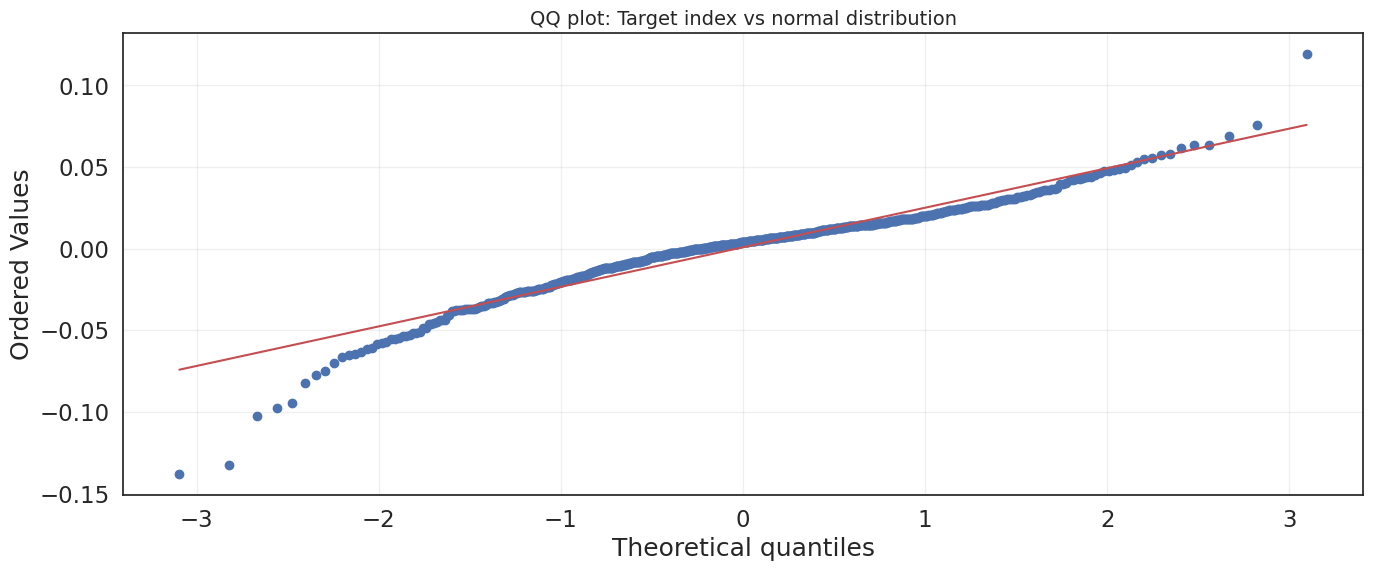

In [ ]:
# QQ-plot for the target index
plt.figure(figsize=(16, 6))

# Plot QQ-plot for the target index
stats.probplot(target_returns_aligned.dropna(), dist="norm", plot=plt)
plt.title(f'QQ plot: Target index vs normal distribution', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

# **4 - Portfolio Replication**

## a) Risk Constraint Settings

The QQ-plot above reveals that the target portfolio returns deviate from normality, exhibiting heavier tails and signs of skewness and excess kurtosis. This non-normal behavior may also be present in the replica portfolio, posing a challenge for risk estimation methods like Value at Risk (VaR), which are sensitive to tail behavior. To address this, we estimate the VaR of the replica portfolio using the Cornish-Fisher expansion, which adjusts for skewness and kurtosis while reducing to the standard Gaussian VaR when returns are normally distributed (in any Gaussian distribution skewness=0 and excess kurtosis=0).
<br>
For regulatory compliance, we adopt a conservative approach by setting the monthly VaR(99%) threshold at 15%, below the 20% limit imposed by EU law.

In [ ]:
# VaR parameters
var_confidence = 0.01  # 1% VaR
var_horizon = 4  # 4 weeks (1 month)
max_var_threshold = 0.15  # 0.15 is a prudential value, since 20% is the real maximum VaR(1%, 1 month)

In [ ]:
def cornish_fisher_var(returns, confidence=0.01, horizon=4):
    """
    Calculate Cornish-Fisher Value at Risk (VaR) for left-skewed return distributions

    Parameters:
    -----------
    returns : list or np.array
        Weekly return data
    confidence_level : float
        Confidence level for VaR
    horizon : int
        Time horizon for VaR calculation

    Returns:
    --------
    float
        VaR estimate (in same units as portfolio_value)
    """
    # Convert returns to numpy array
    returns = np.asarray(returns)

    # Compute basic statistics
    mean_return = np.mean(returns) * horizon
    sigma = np.std(returns, ddof=1) * np.sqrt(horizon)
    skewness = skew(returns) / np.sqrt(horizon)
    excess_kurtosis = kurtosis(returns, fisher=True) / horizon

    # Z-score for the confidence level
    z_score = stats.norm.ppf(confidence)

    # Cornish-Fisher expansion for adjusted z-score
    z_cf = (
        z_score
        + (1/6)*(z_score**2 - 1)*skewness
        + (1/24)*(z_score**3 - 3*z_score)*excess_kurtosis
        - (1/36)*(2*z_score**3 - 5*z_score)*skewness**2
    )

    # Compute VaR
    var = - z_cf * sigma - mean_return

    return var

## b) Replication

In [ ]:
# Ensure data is properly aligned

# Target index returns
y = target_returns_aligned

# Futures returns aligned with target
X = futures_returns.loc[y.index]

# Convert to numpy arrays for easier indexing
X_values = X.values
y_values = y.values
dates_array = X.index.to_numpy()

In [ ]:
def run_ols_with_rolling_window(X_values, y_values, dates_array, rolling_window=52, transaction_cost=0.0005,
                                var_confidence=0.01, var_horizon=4, max_var_threshold=0.15, rebalancing_window=52):
    """
    Use Ordinary Least Squares (OLS) regression for portfolio replication with VaR control and performance calculation

    Parameters:
    -----------
    X_values : np.array
        Array of futures returns
    y_values : np.array
        Array of target returns
    dates_array : np.array
        Array of dates corresponding to the returns
    rolling_window : int
        Number of data points in each training window
    transaction_cost : float
        Per-unit transaction cost applied to weight changes
    var_confidence : float
        Confidence level for VaR calculation
    var_horizon : int
        Time horizon for VaR in periods
    max_var_threshold : float
        Maximum allowed VaR; if exceeded, weights are scaled down to meet this threshold
    rebalancing_window : int
        Number of data points in each rebalancing window

    Returns:
    --------
    dict:
        Dictionary containing various performance metrics and time series data
    """

    # Set the number of assets in replica portfolio
    n_assets = X_values.shape[1]

    # Initialize useful lists
    replica_returns = []
    weights_history = []
    gross_exposures = []
    target_dates = []
    var_values = []
    scaling_factors = []

    # Initialize array of weights useful for computation of transaction cost
    prev_weights = np.zeros(n_assets)

    # Loop over the observations
    for i in range(len(X_values) - rolling_window):

        # Set start and end index of the rolling window for each iteration
        start_idx = i
        end_idx = i + rolling_window

        # Select training data based on the rolling window
        X_train = X_values[start_idx:end_idx]
        y_train = y_values[start_idx:end_idx]

        # Fit OLS on training data without bias term, in order to have a self-financing portfolio
        model_ols = sm.OLS(y_train, X_train)
        results_ols = model_ols.fit()

        # Get current weights for the current iteration
        current_weights = results_ols.params.copy()

        # Initialize scaling factor for current iteration
        scaling_factor = 1.0

        # If at least 12 predictions are made, check VaR constraint
        if len(replica_returns) >= 12:

            # Calculate historical replica returns using current weights
            historical_returns = []

            # Compute historical VaR based on weights of the current interation
            for j in range(max(0, len(replica_returns)-rebalancing_window), len(replica_returns)):

                # Get historical futures returns
                hist_returns = X_values[end_idx-(len(replica_returns)-j)]

                # Calculate weighted historical returns based on the weights of the current iteration
                weighted_return = np.dot(hist_returns, current_weights)
                historical_returns.append(weighted_return)

            # Calculate VaR used Cornish-Fisher quantile approximation
            var = cornish_fisher_var(
                historical_returns,
                confidence=var_confidence,
                horizon=var_horizon
            )

            # Scale weights if VaR exceeds threshold
            if var > max_var_threshold:
                scaling_factor = max_var_threshold / var
                current_weights = current_weights * scaling_factor

                # Recalculate VaR after scaling
                scaled_historical_returns = [ret * scaling_factor for ret in historical_returns]
                scaled_var = cornish_fisher_var(
                    scaled_historical_returns,
                    confidence=var_confidence,
                    horizon=var_horizon
                )

                # Update VaR value after scaling
                var = scaled_var

            # If it was possible to compute VaR, store its value
            var_values.append(var)
        else:

            # If it was not possible to compute VaR, store a NaN
            var_values.append(np.nan)

        # Keep track of the weights' scaling factors
        scaling_factors.append(scaling_factor)

        # Compute gross exposure and store it
        gross_exposure = np.sum(np.abs(current_weights))
        gross_exposures.append(gross_exposure)

        # Keep track of weights history
        weights_history.append(current_weights.copy())

        # If it is possible, compute next week's replica return coonsidering transaction costs
        if end_idx < len(X_values):

            # Select the futures' returns for the observation right after the end of the rolling window
            next_features = X_values[end_idx]

            # Compute transaction costs: if there was a change of weights with respect to the previous iteration, charge 5 basis points per trade
            weights_variation = np.sum(np.abs(current_weights - prev_weights))
            transaction = weights_variation * transaction_cost

            # Compute next week's replica portfolio return taking into account transaction costs
            replica_return = np.dot(next_features, current_weights) - transaction
            replica_returns.append(replica_return)

            # Store next week's date
            target_dates.append(dates_array[end_idx])

            # Store current weights for computation of next iteration's transaction costs
            prev_weights = current_weights.copy()

    # Create a Pandas Series for predicted returns of the replica portfolio
    replica_returns_series = pd.Series(replica_returns, index=target_dates)

    # Create a Pandas Series for target returns aligned with the replica returns
    first_target_date_idx = np.where(dates_array == target_dates[0])[0][0]
    aligned_target_values = y_values[first_target_date_idx : first_target_date_idx + len(replica_returns)]
    aligned_target = pd.Series(aligned_target_values, index=target_dates)

    # Calculate cumulative returns
    cumulative_target = (1 + aligned_target).cumprod()
    cumulative_replica = (1 + replica_returns_series).cumprod()

    # Calculate annualized average returns
    replica_mean_return = replica_returns_series.mean() * 52
    target_mean_return = aligned_target.mean() * 52

    # Calculate annualized volatilities
    replica_vol = replica_returns_series.std() * np.sqrt(52)
    target_vol = aligned_target.std() * np.sqrt(52)

    # Calculate Sharpe ratios
    replica_sharpe = replica_mean_return / replica_vol if replica_vol > 0 else 0
    target_sharpe = target_mean_return / target_vol if target_vol > 0 else 0

    # Calculate tracking error
    tracking_error = (replica_returns_series - aligned_target).std() * np.sqrt(52)

    # Calculate information ratio
    information_ratio = (replica_mean_return - target_mean_return) / tracking_error if tracking_error > 0 else 0

    # Calculate drawdowns
    replica_drawdown = 1 - cumulative_replica / cumulative_replica.cummax()
    target_drawdown = 1 - cumulative_target / cumulative_target.cummax()

    # Calculate correlation
    correlation = replica_returns_series.corr(aligned_target)

    # Calculate average gross exposure
    avg_gross_exposure = np.mean(gross_exposures)

    # Calculate average VaR (excluding NaN values)
    avg_var = np.nanmean(var_values)

    return {
        'rebalancing_window': rebalancing_window,
        'rolling_window': rolling_window,
        'replica_return': replica_mean_return,
        'target_return': target_mean_return,
        'replica_vol': replica_vol,
        'target_vol': target_vol,
        'replica_sharpe': replica_sharpe,
        'target_sharpe': target_sharpe,
        'tracking_error': tracking_error,
        'information_ratio': information_ratio,
        'correlation': correlation,
        'replica_max_drawdown': replica_drawdown.max(),
        'target_max_drawdown': target_drawdown.max(),
        'avg_gross_exposure': avg_gross_exposure,
        'avg_var': avg_var,
        'replica_returns': replica_returns_series,
        'aligned_target': aligned_target,
        'cumulative_replica': cumulative_replica,
        'cumulative_target': cumulative_target,
        'gross_exposures': gross_exposures,
        'var_values': var_values,
        'scaling_factors': scaling_factors,
        'weights_history': weights_history,
        'replica_dates': replica_returns_series.index.tolist(),
        'target_dates': aligned_target.index.tolist()
    }

In [ ]:
# Best parameters
rolling_windows = [26]
rebalancing_windows = [124]

results_normalized = []

# Define rolling window lengths and rebalancing window lengths to test
#rolling_windows = list(range(26, 52 * 5 + 1, 26))
#rebalancing_windows = list(range(4, 4 * 52 + 1, 4))

for window, rebalancing_window in product(rolling_windows, rebalancing_windows):

    # Run the OLS regression
    ols_results = run_ols_with_rolling_window(X_values, y_values, dates_array, rolling_window=window, var_confidence=0.01, var_horizon=4, max_var_threshold=max_var_threshold, rebalancing_window=rebalancing_window)
    results_normalized.append(ols_results)

# Convert results to DataFrame for easier analysis
results_df_normalized = pd.DataFrame(results_normalized)

# Calculate SRRI for each configuration
srri_differences = []
for idx, row in results_df_normalized.iterrows():
    srri_target = calculate_synthetic_risk_reward_indicator(row['aligned_target'])
    srri_replica = calculate_synthetic_risk_reward_indicator(row['replica_returns'])
    srri_diff = abs(srri_target - srri_replica)
    srri_differences.append({
        'index': idx,
        'srri_target': srri_target,
        'srri_replica': srri_replica,
        'srri_difference': srri_diff
    })

# Add SRRI information to the results DataFrame
srri_df = pd.DataFrame(srri_differences)
results_df_normalized = results_df_normalized.merge(srri_df, left_index=True, right_on='index')

# Sort by SRRI difference (lower is better)
sorted_results_normalized = results_df_normalized.sort_values(by='srri_difference', ascending=True)

# Display top 10 configurations by SRRI difference
if len(rolling_windows) > 1 or len(rebalancing_windows) > 1:
  print(f"\nTop {min(10,len(rebalancing_windows)*len(rolling_windows))} configurations by SRRI difference (normalized returns):")
  display(sorted_results_normalized[['rolling_window', 'rebalancing_window', 'srri_target', 'srri_replica',
                                 'srri_difference', 'tracking_error', 'replica_sharpe', 'avg_gross_exposure', 'avg_var']].head(10).round(4))

# Get the best configuration by SRRI difference
best_config_normalized = sorted_results_normalized.iloc[0]
print(f"\nBest configuration by SRRI difference (normalized returns):")
print(f"Rolling window: {best_config_normalized['rolling_window']}")
print(f"Rebalancing window: {best_config_normalized['rebalancing_window']}")
print(f"Target SRRI: {best_config_normalized['srri_target']:.4f}")
print(f"Replica SRRI: {best_config_normalized['srri_replica']:.4f}")
print(f"SRRI difference: {best_config_normalized['srri_difference']:.4f}")
print(f"Tracking error: {best_config_normalized['tracking_error']:.4f}")


Top 10 configurations by SRRI difference (normalized returns):


,rolling_window,rebalancing_window,srri_target,srri_replica,srri_difference,tracking_error,replica_sharpe,avg_gross_exposure,avg_var
30,26,124,0.15,0.1499,0.0001,0.0527,0.2884,3.6776,0.1135
31,26,128,0.15,0.1502,0.0002,0.0528,0.2913,3.6788,0.1140
32,26,132,0.15,0.1504,0.0004,0.0528,0.2916,3.6793,0.1144
29,26,120,0.15,0.1496,0.0004,0.0527,0.2869,3.6766,0.1131
33,26,136,0.15,0.1504,0.0004,0.0528,0.2932,3.6790,0.1147
34,26,140,0.15,0.1505,0.0005,0.0529,0.2946,3.6782,0.1150
35,26,144,0.15,0.1505,0.0005,0.0529,0.2948,3.6771,0.1153
36,26,148,0.15,0.1506,0.0006,0.0534,0.3030,3.6757,0.1156
37,26,152,0.15,0.1507,0.0007,0.0533,0.3037,3.6725,0.1160
28,26,116,0.15,0.1493,0.0007,0.0527,0.2881,3.6763,0.1126



Best configuration by SRRI difference (normalized returns):
Rolling window: 26
Rebalancing window: 124
Target SRRI: 0.1500
Replica SRRI: 0.1499
SRRI difference: 0.0001
Tracking error: 0.0527


In [ ]:
#Compute SRRI for the chosen replica portfolio
best_srri_replica_portfolio = calculate_synthetic_risk_reward_indicator(best_config_normalized['replica_returns'])

# Create detailed metrics table for the best configuration
metrics_normalized = pd.DataFrame({
    'Metric': ['Annualized return', 'Annualized volatility', 'SRRI',  'Sharpe ratio',
               'Max Drawdown','Tracking Error', 'Information ratio',
               'Correlation', 'Average gross exposure', 'Average VaR (1%, 1M)'],
    'Target': [f"{best_config_normalized['target_return']*100:.2f}%",
               f"{best_config_normalized['target_vol']*100:.2f}%",
               f"{srri_target*100:.2f}%",
               f"{best_config_normalized['target_sharpe']:.2f}",
               f"{best_config_normalized['target_max_drawdown']*100:.2f}%",
               "N/A",
               "N/A",
               "N/A",
               "N/A",
               "N/A"],
    'Replica': [f"{best_config_normalized['replica_return']*100:.2f}%",
                f"{best_config_normalized['replica_vol']*100:.2f}%",
                f"{best_srri_replica_portfolio*100:.2f}%",
                f"{best_config_normalized['replica_sharpe']:.2f}",
                f"{best_config_normalized['replica_max_drawdown']*100:.2f}%",
                f"{best_config_normalized['tracking_error']*100:.2f}%",
                f"{best_config_normalized['information_ratio']:.2f}",
                f"{best_config_normalized['correlation']:.4f}",
                f"{best_config_normalized['avg_gross_exposure']:.4f}",
                f"{best_config_normalized['avg_var']*100:.2f}%"]
})

print("\nDetailed metrics for the best configuration (normalized returns):")
display(metrics_normalized)


Detailed metrics for the best configuration (normalized returns):


,Metric,Target,Replica
0,Annualized return,5.64%,4.63%
1,Annualized volatility,17.87%,16.05%
2,SRRI,15.00%,14.99%
3,Sharpe ratio,0.32,0.29
4,Max Drawdown,57.80%,46.44%
5,Tracking Error,N/A,5.27%
6,Information ratio,N/A,-0.19
7,Correlation,N/A,0.9573
8,Average gross exposure,N/A,3.6776
9,"Average VaR (1%, 1M)",N/A,11.35%


## c) Result Visualization

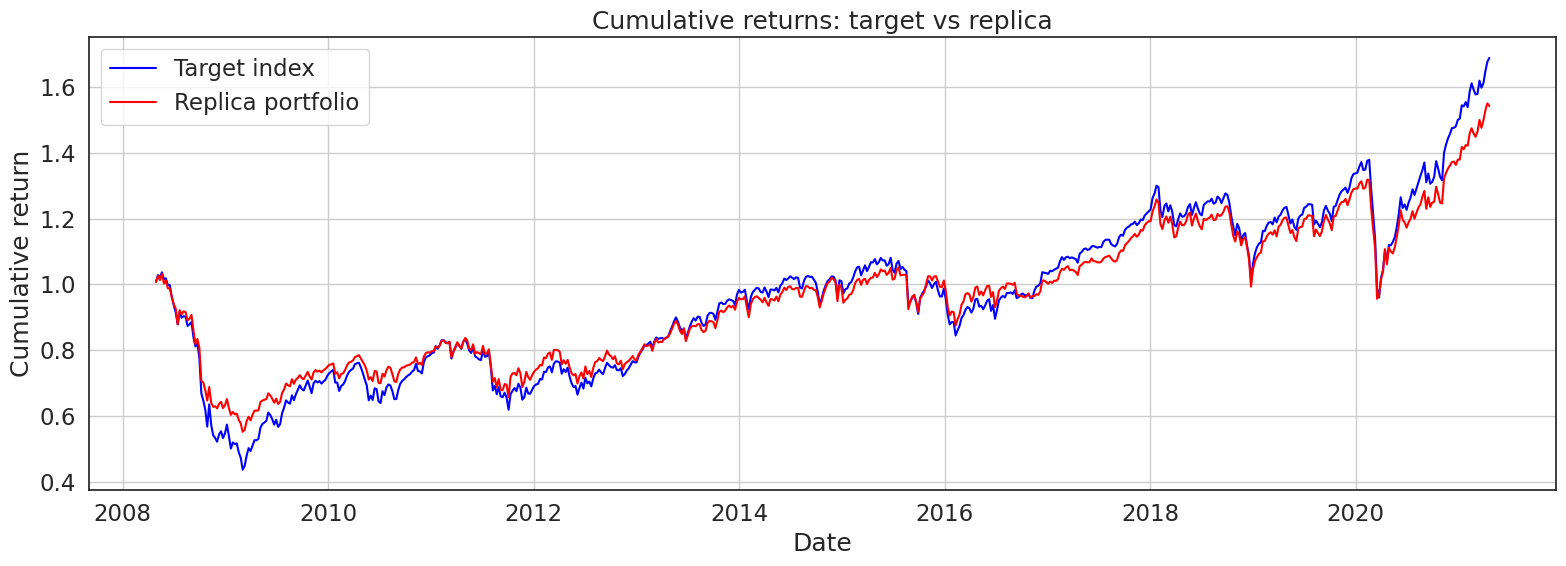

In [ ]:
# Plot cumulative returns
plt.figure(figsize=(16, 6))
plt.plot(best_config_normalized['cumulative_target'], label='Target index', color='blue')
plt.plot(best_config_normalized['cumulative_replica'], label='Replica portfolio', color='red')
plt.title('Cumulative returns: target vs replica')
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

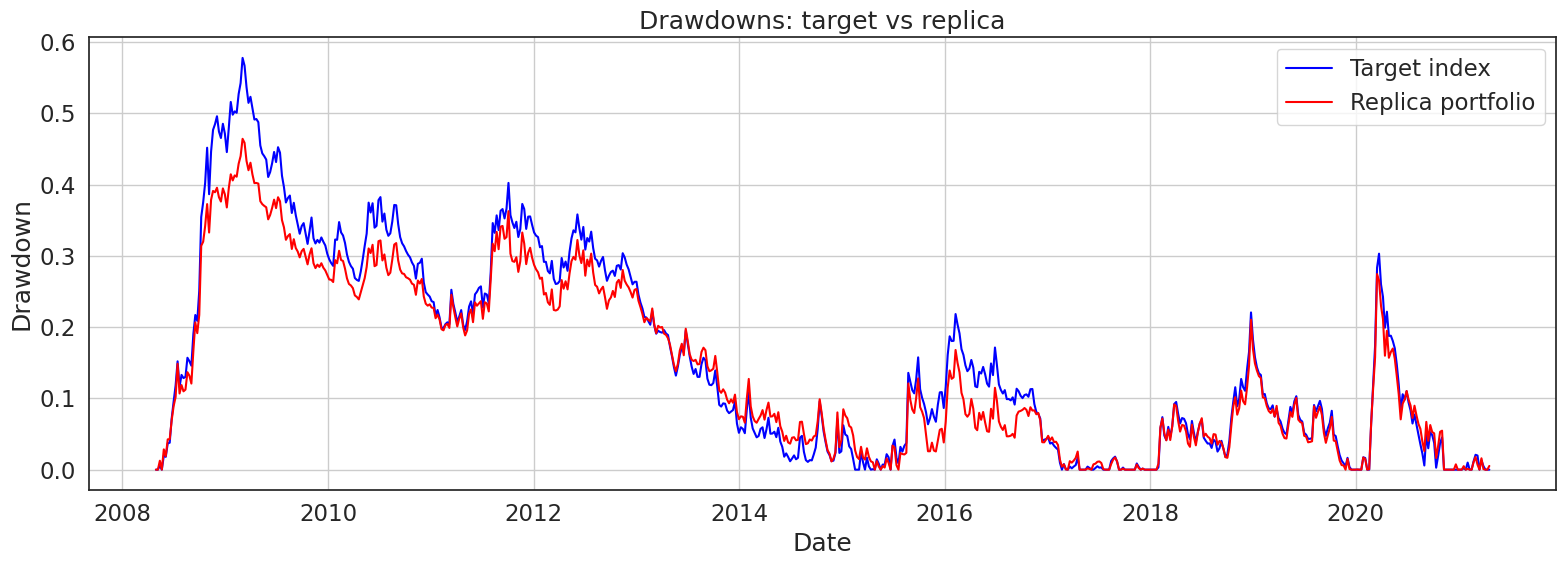

In [ ]:
# Plot drawdowns
plt.figure(figsize=(16,6))
target_drawdown = 1 - best_config_normalized['cumulative_target'] / best_config_normalized['cumulative_target'].cummax()
replica_drawdown = 1 - best_config_normalized['cumulative_replica'] / best_config_normalized['cumulative_replica'].cummax()
plt.plot(target_drawdown, label='Target index', color='blue')
plt.plot(replica_drawdown, label='Replica portfolio', color='red')
plt.title('Drawdowns: target vs replica')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

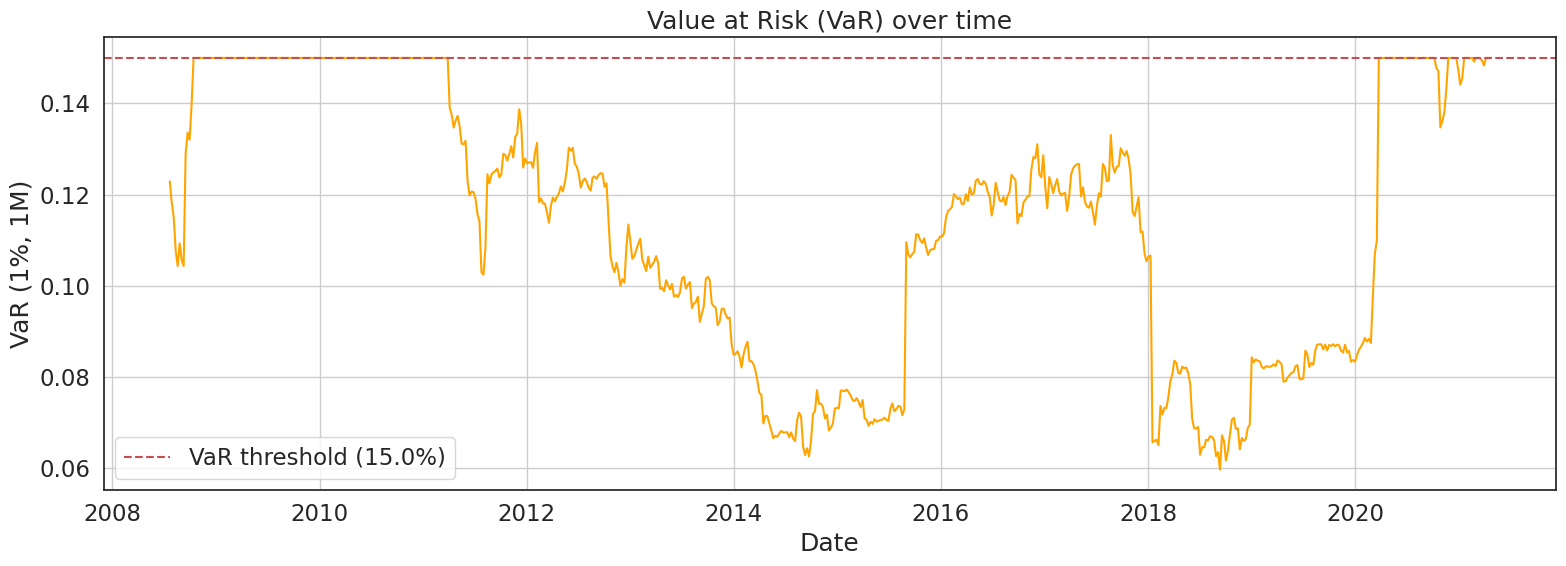

In [ ]:
# Plot VaR over time
plt.figure(figsize=(16,6))
var_series = pd.Series(best_config_normalized['var_values'], index=best_config_normalized['replica_returns'].index)
plt.plot(var_series, color='orange')
plt.axhline(y=max_var_threshold, color='r', linestyle='--', label=f'VaR threshold ({max_var_threshold*100}%)')
plt.title('Value at Risk (VaR) over time')
plt.xlabel('Date')
plt.ylabel('VaR (1%, 1M)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

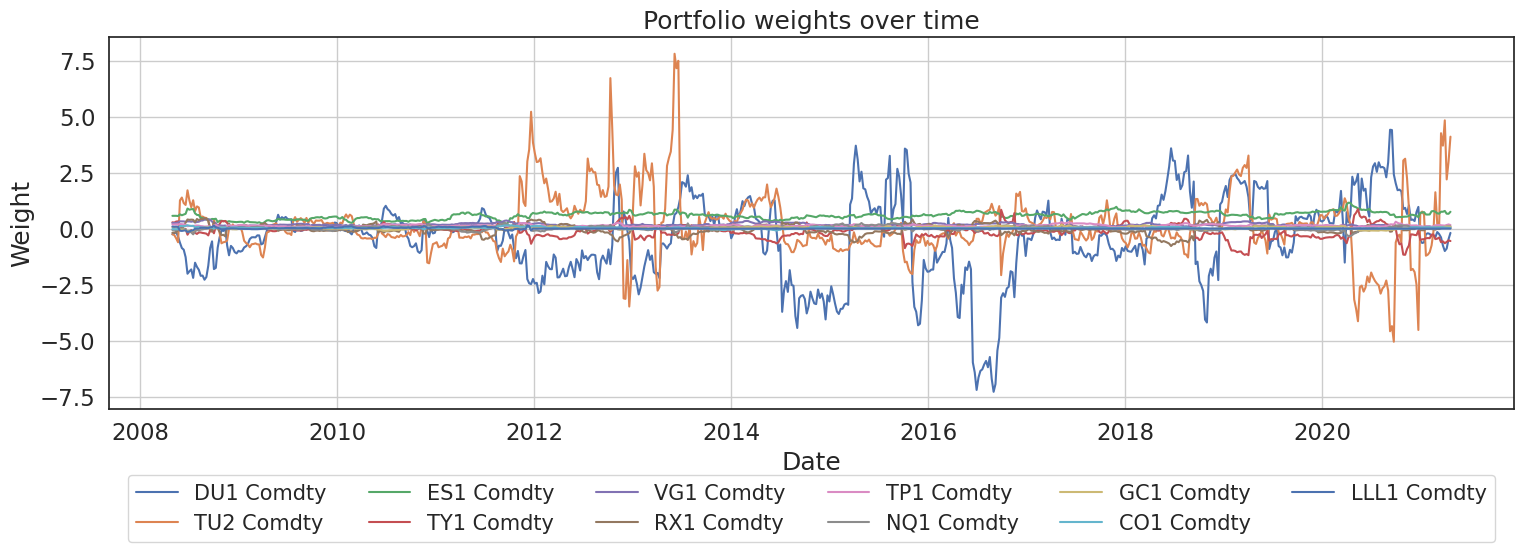

In [ ]:
# Plot weights over time
weights_history = best_config_normalized['weights_history']
weights_df = pd.DataFrame(weights_history, index=best_config_normalized['replica_returns'].index)

# Get the column names from the original futures data
weights_df.columns = X.columns

# Plot the weights by absolute average value
top_weights = weights_df.abs().mean().sort_values(ascending=False).head(len(futures_contracts)).index
plt.figure(figsize=(16, 6))
for col in top_weights:
    plt.plot(weights_df[col], label=col)
plt.title('Portfolio weights over time')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center',
          ncol=6, fontsize='small')
plt.tight_layout()
plt.grid(True)
plt.show()

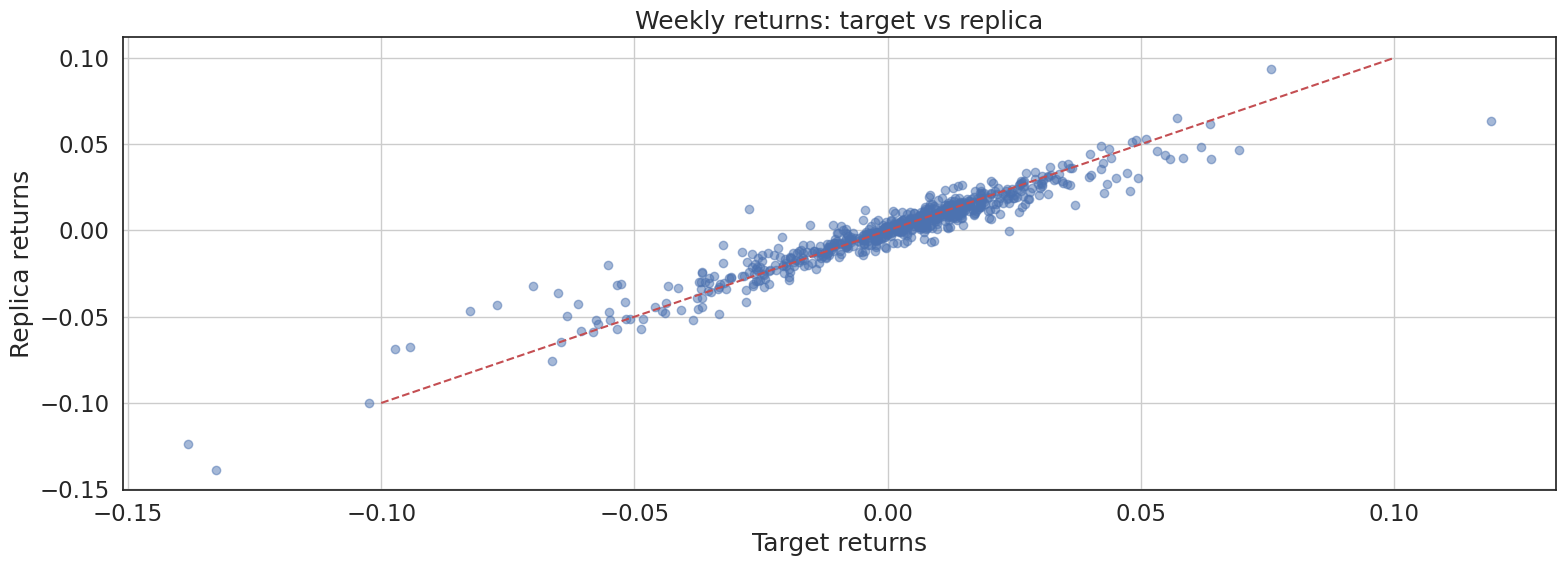

In [ ]:
# Plot weekly returns
plt.figure(figsize=(16,6))
plt.scatter(best_config_normalized['aligned_target'], best_config_normalized['replica_returns'], alpha=0.5)
plt.plot([-0.1, 0.1], [-0.1, 0.1], 'r--')  # Diagonal line
plt.title('Weekly returns: target vs replica')
plt.xlabel('Target returns')
plt.ylabel('Replica returns')
plt.grid(True)
plt.tight_layout()
plt.show()